<a href="https://colab.research.google.com/github/kaniarasann/Langchain/blob/main/02_LangGraph_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [440]:
!pip install langgraph langchain_groq langchain langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


Tool Management

In [406]:
def add_two_number(a:int,b:int) -> int:
    """
    This function add two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: Sum of two valus
    """
    int_a = int(a)
    int_b = int(b)

    return int_a+int_b

Model

In [407]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict,Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

LLM With Tools

In [408]:
from langchain_groq import ChatGroq
from google.colab import userdata

llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    api_key= userdata.get("groq_key")
)

llm_bind_tools = llm.bind_tools([add_two_number])

Invoke LLM

In [409]:
invoke_llm.tool_calls

[{'name': 'add_two_number',
  'args': {'a': 2, 'b': 5},
  'id': 'q9t6wek5e',
  'type': 'tool_call'}]

LangGraph Tool Calling

In [410]:
def llm_tool_calling(state: State) -> State:
    """
    This function is called to invoke the LLM with tools.

    :param state: The current state containing messages
    :return: Updated state with the response from the LLM
    """
    response = llm_bind_tools.invoke(state["messages"])
    state["messages"].append(response)
    return state

In [411]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [412]:
graph = StateGraph(State)

In [413]:
graph.add_node("llm", llm_tool_calling)
graph.add_node("tools", ToolNode(tools=[add_two_number]))

In [414]:
graph.add_edge(START, "llm")
graph.add_conditional_edges("llm", tools_condition)
graph.add_edge("tools", END)

In [415]:
graph_builder = graph.compile()

Print and verify the created Graph

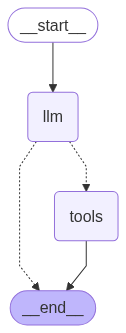

In [416]:
from IPython.display import display, Image
display(Image(graph_builder.get_graph().draw_mermaid_png()))

Invoke LLM

In [417]:
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage
state = State(messages= HumanMessage(content="Add two number 2 and 5"))

In [418]:
output = graph_builder.invoke(state)

In [419]:
import pprint
for msg in output['messages']:
     msg.pretty_print()

================================ Human Message =================================

Add two number 2 and 5
================================== Ai Message ==================================
Tool Calls:
  add_two_number (bvd7aeva0)
 Call ID: bvd7aeva0
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: add_two_number

7


We can also chain one or more tools togethor

In [420]:
def subtract_two_number(a:int,b:int) -> int:
    """_summary_
     This function subtract two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: Subtract two valus
    """
    int_a = int(a)
    int_b = int(b)

    return a-b

def multiply_two_number(a:int,b:int) -> int:
    """_summary_
     This function multiply two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: multiply two valus
    """
    int_a = int(a)
    int_b = int(b)

    return a*b


In [421]:
multiple_tool_graph = StateGraph(State)

In [422]:
multiple_tool_graph.add_node("llm", llm_tool_calling)
multiple_tool_graph.add_node("tools", ToolNode(tools=[add_two_number,subtract_two_number,multiply_two_number]))

In [423]:
multiple_tool_graph.add_edge(START, "llm")
multiple_tool_graph.add_conditional_edges("llm", tools_condition)
multiple_tool_graph.add_edge("tools", END)

In [424]:
graph_builder_multiple_tools = multiple_tool_graph.compile()

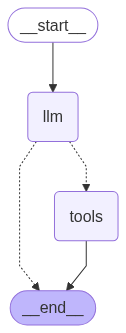

In [425]:
display(Image(graph_builder_multiple_tools.get_graph().draw_mermaid_png()))

In [426]:
state_message = State(messages= HumanMessage(content="""Add two number 2 and 5 then multiply it with 10 and
                                                        Subtract it with 3 """))

In [427]:
result = graph_builder_multiple_tools.invoke(state_message)

In [428]:
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

Add two number 2 and 5 then multiply it with 10 and
                                                        Subtract it with 3 
================================== Ai Message ==================================

To solve the problem:

1. **Add** the two numbers: 2 + 5 = 7
2. **Multiply** the sum by 10: 7 × 10 = 70
3. **Subtract** 3 from the result: 70 - 3 = 67

**Answer:** 67


Agent without memory

In [429]:
#output_res = graph_builder_multiple_tools.invoke(HumanMessage(content="what is the output from previous query" ))

In [430]:
# for item in output_res['messages']:
#     item.pretty_print()

Agent with memory

In [431]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [432]:
multiple_tool_graph = StateGraph(State)
multiple_tool_graph.add_node("llm", llm_tool_calling)
multiple_tool_graph.add_node("tools", ToolNode(tools=[add_two_number,subtract_two_number,multiply_two_number]))
multiple_tool_graph.add_edge(START, "llm")
multiple_tool_graph.add_conditional_edges("llm", tools_condition)
multiple_tool_graph.add_edge("tools", END)
graph_builder_memory = multiple_tool_graph.compile(checkpointer=memory)

In [433]:
state_message = State(messages= HumanMessage(content="Add two number 2 and 5 and then multiply it with 10 and subtarct it with 5"))

In [434]:
config = {"configurable":{"thread_id":"1"}}

In [435]:
graph_builder_memory.invoke(state_message,config)

{'messages': [HumanMessage(content='Add two number 2 and 5 and then multiply it with 10 and subtarct it with 5', additional_kwargs={}, response_metadata={}, id='e412414f-145e-4e82-ab95-cf27c343cc97'),
  AIMessage(content='To solve the problem step-by-step:\n\n1. **Add 2 and 5:**\n   \\[\n   2 + 5 = 7\n   \\]\n\n2. **Multiply the result by 10:**\n   \\[\n   7 \\times 10 = 70\n   \\]\n\n3. **Subtract 5 from the result:**\n   \\[\n   70 - 5 = 65\n   \\]\n\n**Final Answer:** 65', additional_kwargs={'reasoning_content': 'Okay, so the user is asking me to add two numbers, 2 and 5, and then multiply the result by 10 and subtract 5. Let me break this down step by step. First, I need to add 2 and 5, which gives me 7. Next, I multiply 7 by 10, resulting in 70. Then, I subtract 5 from 70, which leaves me with 65. So the final answer should be 65. I should make sure each step is clear so the user can follow along easily.\n'}, response_metadata={'token_usage': {'completion_tokens': 218, 'prompt_tok

In [436]:
res = graph_builder_memory.invoke(HumanMessage(content="add 25 to that number" ),config)

In [437]:
for item in res['messages']:
  item.pretty_print()

================================ Human Message =================================

Add two number 2 and 5 and then multiply it with 10 and subtarct it with 5
================================== Ai Message ==================================

To solve the problem step-by-step:

1. **Add 2 and 5:**
   \[
   2 + 5 = 7
   \]

2. **Multiply the result by 10:**
   \[
   7 \times 10 = 70
   \]

3. **Subtract 5 from the result:**
   \[
   70 - 5 = 65
   \]

**Final Answer:** 65
================================== Ai Message ==================================


In [438]:
res_memory = graph_builder_memory.invoke(HumanMessage(content="Add 35 to that valie" ),config)

In [439]:
for item in res_memory['messages']:
  item.pretty_print()

================================ Human Message =================================

Add two number 2 and 5 and then multiply it with 10 and subtarct it with 5
================================== Ai Message ==================================

To solve the problem step-by-step:

1. **Add 2 and 5:**
   \[
   2 + 5 = 7
   \]

2. **Multiply the result by 10:**
   \[
   7 \times 10 = 70
   \]

3. **Subtract 5 from the result:**
   \[
   70 - 5 = 65
   \]

**Final Answer:** 65
================================== Ai Message ==================================
================================== Ai Message ==================================



To solve the problem step-by-step:

1. **Add 2 and 5:**
   \[
   2 + 5 = 7
   \]

2. **Multiply the result by 10:**
   \[
   7 \times 10 = 70
   \]

3. **Subtract 5 from the result:**
   \[
   70 - 5 = 65
   \]

**Final Answer:** 65
